# Create UV-Vis Dataset for E3NN Machine Learning

### Download Modules

In [2]:
#%%capture
!pip install PubChemPy 

In [3]:
import pandas as pd
import numpy as np
import io
import sys

from openbabel import pybel


# Import modules
import nglview as nv
import ase.io
import matplotlib.pyplot as plt
import rdkit
import pubchempy as pcp

# Load psi4 to compute orbitals
import psi4


### Download UV-Vis data

In [1]:
! wget https://raw.githubusercontent.com/PNNL-CompBio/ML_UVvisModels/main/Data/UV_w_SMILES.csv

--2024-07-02 04:08:38--  https://raw.githubusercontent.com/PNNL-CompBio/ML_UVvisModels/main/Data/UV_w_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3442000 (3.3M) [text/plain]
Saving to: ‘UV_w_SMILES.csv.1’

UV_w_SMILES.csv.1   100%[===================>]   3.28M  --.-KB/s    in 0.04s   

2024-07-02 04:08:38 (82.4 MB/s) - ‘UV_w_SMILES.csv.1’ saved [3442000/3442000]



### Load data in Pandas

In [4]:
import pandas as pd

In [4]:
# Define the file path to the CSV file containing UV-Vis data with SMILES strings
uvvis_file = "UV_w_SMILES.csv"

# Read the CSV file into a pandas DataFrame
uvvis_data = pd.read_csv(uvvis_file,header=None)

# Display the contents of the DataFrame
uvvis_data

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
0,NC1=NC2=C(C=CC=C2)[N+]([O-])=N1,0.299539,0.311787,0.328491,0.349915,0.376548,0.408694,0.446354,0.489792,0.537421,...,0.092434,0.095006,0.097484,0.099952,0.102239,0.104428,0.106597,0.108721,0.110758,0.112611
1,NC1=NC2=C(C=CC=C2)N=N1,0.411922,0.447550,0.487158,0.530422,0.576958,0.626523,0.678088,0.731087,0.783621,...,0.094415,0.095031,0.095445,0.095832,0.095950,0.095919,0.095820,0.095594,0.095204,0.094772
2,CCC1=[N+]([O-])C2=C(C=CC=C2)[N+]([O-])=N1,0.732482,0.794217,0.853497,0.907398,0.952023,0.983787,1.000000,0.998714,0.982111,...,0.398864,0.409874,0.420358,0.429326,0.437889,0.445579,0.452843,0.459056,0.464107,0.468328
3,CN(C)CC1=CNC2=CC=C(C=C12)[N+]([O-])=O,0.412611,0.399813,0.390055,0.382307,0.376957,0.373062,0.371521,0.370622,0.371992,...,0.033980,0.029478,0.024774,0.020789,0.017146,0.013311,0.009733,0.006266,0.003120,0.000000
4,NC(=N)SCCN1C(=O)C2=CC=CC=C2C1=O,0.991241,1.000000,0.996943,0.979253,0.944010,0.890630,0.820660,0.739217,0.655266,...,0.000543,0.000694,0.000529,0.000495,0.000374,0.000433,0.000577,0.000560,0.000574,0.000412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,c1csc(c1)-c1ncc2ccccn12,0.780693,0.749204,0.723286,0.700154,0.678959,0.664063,0.651104,0.639720,0.630878,...,0.022660,0.018397,0.015018,0.011409,0.009047,0.006746,0.004517,0.002713,0.001453,0.000000
928,c1coc(c1)-c1ccnc2nncn12,0.646698,0.659208,0.668289,0.674135,0.676552,0.674330,0.668094,0.656831,0.642216,...,0.000538,0.000339,0.000440,0.000230,0.000327,0.000148,0.000129,0.000055,0.000000,0.000164
929,Nc1nc(cs1)-c1cccs1,0.588011,0.585420,0.584680,0.585494,0.588826,0.593638,0.601041,0.610887,0.623694,...,0.000496,0.000444,0.000807,0.000770,0.001036,0.000355,0.000222,0.000496,0.000000,0.000155
930,Nc1nccc(n1)-c1cccs1,0.687236,0.686341,0.680750,0.670685,0.658608,0.642728,0.622375,0.595983,0.564895,...,0.002908,0.002147,0.003086,0.002348,0.001141,0.001364,0.000470,0.000403,0.000000,0.000716


In [5]:
def tanimoto(compound1, compound2):
    fp1 = int(compound1.fingerprint, 16)
    fp2 = int(compound2.fingerprint, 16)
    fp1_count = bin(fp1).count('1')
    fp2_count = bin(fp2).count('1')
    both_count = bin(fp1 & fp2).count('1')
    return float(both_count) / (fp1_count + fp2_count - both_count)

In [6]:
# Initialize the DataFrame
df = pd.DataFrame(columns=['id', 'SMILES', 'name', 'phfreq', 'phdos', 'pdos', 'formula', 'species', 'smiles','expt','comp'])

### Convert SMILES to Skeletal Structure

In [7]:
for index1, row1 in uvvis_data.iterrows():
    for index2, row2 in uvvis_data.iterrows():
        try:
            compound1=pcp.get_compounds(row1[0],namespace='smiles')[0]
            compound2=pcp.get_compounds(row2[0],namespace='smiles')[0]
            print(compound2)
        except:
            pass
        if compound1.fingerprint and compound2.fingerprint:
            similarity = tanimoto(compound1, compound2)
            print(similarity)
        else:
            print(f"missing fingerprint for either mol{index1}: {row1[0]} or mol{index2}: {row2[0]}")
            
        if index2>10:
            break
    break

Compound(79470)
1.0
Compound(88336)
0.958041958041958
Compound(9837000)
0.6688741721854304
Compound(18882)
0.5412371134020618
Compound(416363)
0.34
Compound(283185)
0.6102564102564103
Compound()
missing fingerprint for either mol0: NC1=NC2=C(C=CC=C2)[N+]([O-])=N1 or mol6: COC(=O)NCC1=NC2=CC(C)=C(C)C=C2N1
Compound(229765)
0.21212121212121213
Compound(279337)
0.5741626794258373
Compound()
missing fingerprint for either mol0: NC1=NC2=C(C=CC=C2)[N+]([O-])=N1 or mol9: CSC(=S)N\N=C/C1=C(Cl)C=C(Cl)C=C1
Compound(9648074)
0.34615384615384615
Compound(5334616)
0.5445544554455446


In [8]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np

# Assume df is your DataFrame with a column 'smiles'
fps = []
for index, row in uvvis_data.iterrows():
#for s in df['smiles']:
    mol = Chem.MolFromSmiles(row[0])
    if mol is None:
        fps.append(None)
    else:
        fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))


# build empty matrix
n = len(fps)
sim_mat = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        if fps[i] is None or fps[j] is None:
            sim = np.nan
        else:
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        sim_mat[i, j] = sim_mat[j, i] = sim

print(sim_mat)

# sim_df = pd.DataFrame(sim_mat,
#                       index=df.index,
#                       columns=df.index)

[[1.         0.43333333 0.38888889 ... 0.2        0.21428571 0.09836066]
 [0.43333333 1.         0.15384615 ... 0.22857143 0.24324324 0.14814815]
 [0.38888889 0.15384615 1.         ... 0.11111111 0.10416667 0.0952381 ]
 ...
 [0.2        0.22857143 0.11111111 ... 1.         0.54545455 0.09836066]
 [0.21428571 0.24324324 0.10416667 ... 0.54545455 1.         0.12903226]
 [0.09836066 0.14814815 0.0952381  ... 0.09836066 0.12903226 1.        ]]


In [9]:
import pandas as pd

# 1. Assume df is your original DataFrame with df['smiles']
# 2. sim_mat is the (932×932) numpy array of similarities

# Create a Series of numeric IDs
ids = pd.Series(range(0, len(uvvis_data)), name='ID')

# Build the similarity DataFrame, labeling both axes 1–932
sim_wide = pd.DataFrame(sim_mat,
                        index=ids,
                        columns=ids)

# Now concatenate ID, SMILES, and the sim matrix side by side
wide_df = pd.concat([
    ids,
    uvvis_data[0].rename('SMILES'),
    sim_wide
], axis=1)

# wide_df now has columns: ['ID','SMILES', 1,2,...,932]
wide_df.head()

,ID,SMILES,0,1,2,3,4,5,6,7,...,922,923,924,925,926,927,928,929,930,931
0,0,NC1=NC2=C(C=CC=C2)[N+]([O-])=N1,1.000000,0.433333,0.388889,0.072727,0.130435,0.090909,0.092593,0.021739,...,0.104167,0.111111,0.111111,0.113636,0.142857,0.125000,0.100000,0.200000,0.214286,0.098361
1,1,NC1=NC2=C(C=CC=C2)N=N1,0.433333,1.000000,0.153846,0.080000,0.175000,0.122449,0.102041,0.024390,...,0.116279,0.125000,0.125000,0.128205,0.159091,0.139535,0.136364,0.228571,0.243243,0.148148
2,2,CCC1=[N+]([O-])C2=C(C=CC=C2)[N+]([O-])=N1,0.388889,0.153846,1.000000,0.109091,0.125000,0.087719,0.089286,0.020833,...,0.170213,0.130435,0.130435,0.133333,0.094340,0.120000,0.096154,0.111111,0.104167,0.095238
3,3,CN(C)CC1=CNC2=CC=C(C=C12)[N+]([O-])=O,0.072727,0.080000,0.109091,1.000000,0.086207,0.126984,0.129032,0.054545,...,0.103448,0.089286,0.089286,0.090909,0.080645,0.065574,0.064516,0.053571,0.068966,0.068493
4,4,NC(=N)SCCN1C(=O)C2=CC=CC=C2C1=O,0.130435,0.175000,0.125000,0.086207,1.000000,0.084746,0.086207,0.085106,...,0.163265,0.148936,0.148936,0.514286,0.090909,0.115385,0.134615,0.106383,0.100000,0.126984


In [10]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# --- Slider & output widget ---
slider = widgets.IntRangeSlider(
    value=[1, 100],
    min=1, max=932, step=1,
    description='ID range:',
    continuous_update=False  # only redraw on release
)
out = widgets.Output()

# --- Update function ---
def update_heatmap(change):
    lo, hi = change['new']
    # slice sim_df by numeric IDs
    sub = wide_df.loc[lo:hi, lo:hi]

    fig = px.imshow(
        sub.values,
        x=sub.columns, y=sub.index,
        labels={'x':'Mol ID', 'y':'Mol ID', 'color':'Tanimoto'},
        aspect='auto',
        zmin=0, zmax=1
    )
    fig.update_layout(width=600, height=600, margin=dict(l=40, r=40, t=40, b=40))
    
    out.clear_output(wait=True)
    with out:
        fig.show()

# --- Wire it up and display ---
slider.observe(update_heatmap, 'value')
display(slider, out)

# draw initial view
update_heatmap({'new': slider.value})


IntRangeSlider(value=(1, 100), continuous_update=False, description='ID range:', max=932, min=1)

Output()

/opt/conda/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



ValueError: could not convert string to float: 'NC1=NC2=C(C=CC=C2)[N+]([O-])=N1'

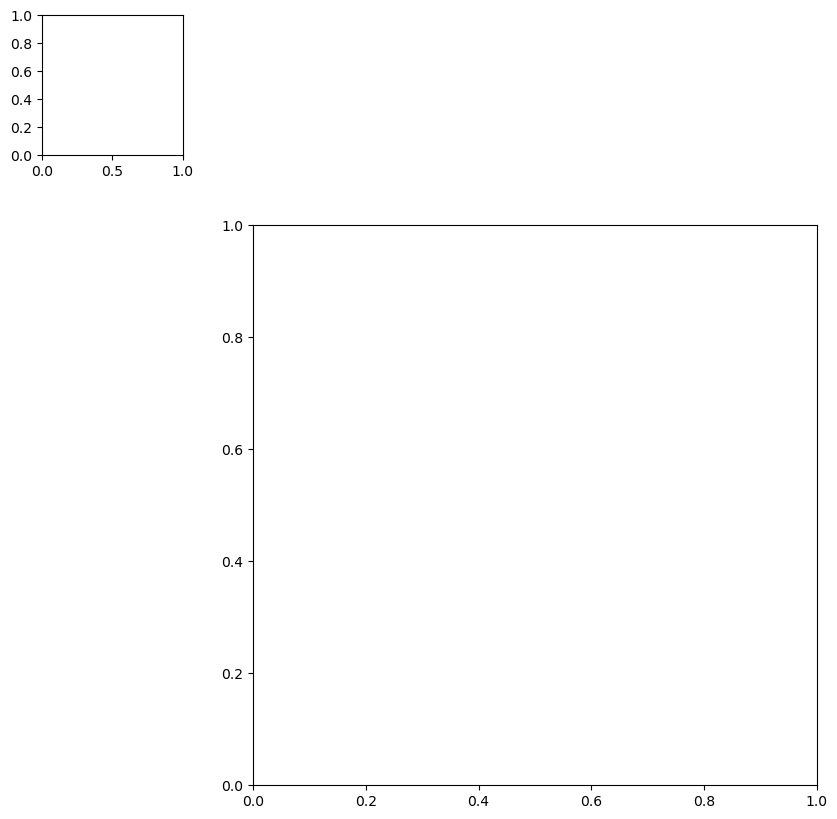

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# cluster similar molecules and draw a clustermap
sns.clustermap(wide_df,
               cmap='viridis',
               linewidths=0.5,
               figsize=(10,10))
plt.show()

In [12]:
import plotly.express as px

fig = px.imshow(wide_df,
                labels=dict(x="Compound", y="Compound", color="Tanimoto"),
                x=df['smiles'],  # or a separate name/ID column
                y=df['smiles'])
fig.update_layout(width=800, height=800)
fig.show()

ValueError: The length of the y vector must match the length of the first dimension of the img matrix.

In [ ]:
    # Create a dictionary for the new row
    panda_row = {
        'uvvis_id': index,
        'structure': atoms_to_dict(mol),
        'name': name,
        'phfreq': x_reduced.tolist(),
        'phdos': y_reduced.tolist(),
        'pdos': [],
        'formula': formula_string,
        'species': species_list,
        'smiles': smiles,
        'expt': y_reduced.tolist(),
        'comp': y_reduced.tolist()
    }

    # Append the new row to the DataFrame
    new_data = pd.DataFrame([panda_row])
    df = pd.concat([df, new_data], ignore_index=True)

In [148]:
for i in range(932):
    smi_string = uvvis_data.iloc[i, 0]